In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!wget https://github.com/NVlabs/earth2grid/archive/refs/tags/v2024.8.1.tar.gz

--2025-05-08 18:37:26--  https://github.com/NVlabs/earth2grid/archive/refs/tags/v2024.8.1.tar.gz
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/NVlabs/earth2grid/tar.gz/refs/tags/v2024.8.1 [following]
--2025-05-08 18:37:26--  https://codeload.github.com/NVlabs/earth2grid/tar.gz/refs/tags/v2024.8.1
Resolving codeload.github.com (codeload.github.com)... 20.27.177.114
Connecting to codeload.github.com (codeload.github.com)|20.27.177.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘v2024.8.1.tar.gz’

v2024.8.1.tar.gz        [ <=>                ] 152.13K  --.-KB/s    in 0.1s    

2025-05-08 18:37:27 (1.03 MB/s) - ‘v2024.8.1.tar.gz’ saved [155784]



In [3]:
!tar -xvf v2024.8.1.tar.gz

earth2grid-2024.8.1/
earth2grid-2024.8.1/.bumpversion.cfg
earth2grid-2024.8.1/.editorconfig
earth2grid-2024.8.1/.github/
earth2grid-2024.8.1/.github/ISSUE_TEMPLATE.md
earth2grid-2024.8.1/.github/workflows/
earth2grid-2024.8.1/.github/workflows/ci.yml
earth2grid-2024.8.1/.gitignore
earth2grid-2024.8.1/.gitlab-ci.yml
earth2grid-2024.8.1/.pre-commit-config.yaml
earth2grid-2024.8.1/CHANGELOG.md
earth2grid-2024.8.1/CONTRIBUTING.md
earth2grid-2024.8.1/LICENSE.txt
earth2grid-2024.8.1/README.md
earth2grid-2024.8.1/docs/
earth2grid-2024.8.1/docs/.gitignore
earth2grid-2024.8.1/docs/Makefile
earth2grid-2024.8.1/docs/api.rst
earth2grid-2024.8.1/docs/changelog.md
earth2grid-2024.8.1/docs/conf.py
earth2grid-2024.8.1/docs/contributing.md
earth2grid-2024.8.1/docs/image_scraper.py
earth2grid-2024.8.1/docs/img/
earth2grid-2024.8.1/docs/img/image.jpg
earth2grid-2024.8.1/docs/index.rst
earth2grid-2024.8.1/docs/installation.md
earth2grid-2024.8.1/docs/make.bat
earth2grid-2024.8.1/docs/push_docs.sh
earth2gr

In [4]:
!pip install --no-build-isolation /content/earth2grid-2024.8.1

Processing ./earth2grid-2024.8.1
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Healpix to lat-lon

In [5]:
import earth2grid
import torch
level = 6
hpx = earth2grid.healpix.Grid(level=level, pixel_order=earth2grid.healpix.XY())
src = earth2grid.latlon.equiangular_lat_lon_grid(32, 64)
z_torch = torch.cos(torch.deg2rad(torch.tensor(src.lat)))
z_torch = z_torch.broadcast_to(src.shape)
regrid = earth2grid.get_regridder(src, hpx)
z_hpx = regrid(z_torch)
nside = 2**level
reshaped = z_hpx.reshape(12, nside, nside)
lat_r = hpx.lat.reshape(12, nside, nside)
lon_r = hpx.lon.reshape(12, nside, nside)

In [6]:
import numpy as np
import torch

import earth2grid

device = "cpu"


# the source grid (from 90N to 90S and 0E to 360E)
ll = earth2grid.latlon.equiangular_lat_lon_grid(721, 1440)

# a 2d grid of target lat lons
target_lat = np.linspace(30, 50, 32)
target_lon = np.linspace(100, 120, 64)
target_lat, target_lon = np.meshgrid(target_lat, target_lon)

# Some source data on the original grid
data = torch.ones([721, 1440]).to(device)

# Create a bilinear regridding object earth2grid
regrid = ll.get_bilinear_regridder_to(target_lat, target_lon)

# need to move the weights to same device and dtype as data
regrid.to(data)

# perform the regridding
out = regrid(data)
assert out.shape == target_lat.shape  # noqa
print("data shape", out.shape)

data shape torch.Size([64, 32])


# Lat-lon to Healpix

In [7]:
import torch
import earth2grid

def latlon_to_healpix(data: torch.Tensor, level: int = 6, device: str = "cpu"):
    """
    Regrid 2D lat-lon data to HEALPix format using earth2grid.

    Args:
        data (torch.Tensor): 2D tensor of shape [nlat, nlon].
        level (int): HEALPix resolution level (default: 6 → nside=64).
        device (str): Device to perform computation on ("cpu" or "cuda").

    Returns:
        data_hpx (torch.Tensor): Flat HEALPix data of shape [12 * nside * nside].
        data_faces (torch.Tensor): Reshaped HEALPix data of shape [12, nside, nside].
    """
    # Make sure data is on the correct device
    data = data.to(device)

    # Get source grid matching data shape
    nlat, nlon = data.shape
    src = earth2grid.latlon.equiangular_lat_lon_grid(nlat, nlon)

    # Create HEALPix target grid
    hpx = earth2grid.healpix.Grid(level=level, pixel_order=earth2grid.healpix.XY())
    nside = 2 ** level

    # Create and prepare regridder
    regrid = earth2grid.get_regridder(src, hpx)
    regrid.to(data)

    # Perform regridding
    data_hpx = regrid(data)
    data_faces = data_hpx.reshape(12, nside, nside)

    return data_hpx, data_faces

# Example data: 721 x 1440 grid
data = torch.ones([721, 1440])

# Regrid to HEALPix level 6
data_hpx, data_faces = latlon_to_healpix(data, level=6)

print("Flat HEALPix shape:", data_hpx.shape)       # torch.Size([49152])
print("Face-wise shape:", data_faces.shape)        # torch.Size([12, 64, 64])

Flat HEALPix shape: torch.Size([49152])
Face-wise shape: torch.Size([12, 64, 64])


In [8]:
!wget https://raw.githubusercontent.com/manmeet3591/download_mars_reanalysis/refs/heads/main/max_vals_mars.nc
!wget https://raw.githubusercontent.com/manmeet3591/download_mars_reanalysis/refs/heads/main/min_vals_mars.nc

--2025-05-08 18:41:42--  https://raw.githubusercontent.com/manmeet3591/download_mars_reanalysis/refs/heads/main/max_vals_mars.nc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3284 (3.2K) [application/octet-stream]
Saving to: ‘max_vals_mars.nc’

max_vals_mars.nc    100%[===================>]   3.21K  --.-KB/s    in 0s      

2025-05-08 18:41:42 (80.5 MB/s) - ‘max_vals_mars.nc’ saved [3284/3284]

--2025-05-08 18:41:42--  https://raw.githubusercontent.com/manmeet3591/download_mars_reanalysis/refs/heads/main/min_vals_mars.nc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request s

In [9]:
import xarray as xr
ds_min = xr.open_dataset('min_vals_mars.nc')
ds_max = xr.open_dataset('max_vals_mars.nc')

In [10]:
!ls /content/drive/MyDrive/mars_reanalysis/

emars_v1.0_anal_mean_MY24_Ls090-120.nc	emars_v1.0_anal_mean_MY29_Ls090-120.nc
emars_v1.0_anal_mean_MY24_Ls120-150.nc	emars_v1.0_anal_mean_MY29_Ls120-150.nc
emars_v1.0_anal_mean_MY24_Ls150-180.nc	emars_v1.0_anal_mean_MY29_Ls150-180.nc
emars_v1.0_anal_mean_MY24_Ls180-210.nc	emars_v1.0_anal_mean_MY29_Ls180-210.nc
emars_v1.0_anal_mean_MY24_Ls210-240.nc	emars_v1.0_anal_mean_MY29_Ls210-240.nc
emars_v1.0_anal_mean_MY24_Ls240-270.nc	emars_v1.0_anal_mean_MY29_Ls240-270.nc
emars_v1.0_anal_mean_MY24_Ls270-300.nc	emars_v1.0_anal_mean_MY29_Ls270-300.nc
emars_v1.0_anal_mean_MY24_Ls300-330.nc	emars_v1.0_anal_mean_MY29_Ls300-330.nc
emars_v1.0_anal_mean_MY24_Ls330-360.nc	emars_v1.0_anal_mean_MY29_Ls330-360.nc
emars_v1.0_anal_mean_MY25_Ls000-030.nc	emars_v1.0_anal_mean_MY30_Ls000-030.nc
emars_v1.0_anal_mean_MY25_Ls030-060.nc	emars_v1.0_anal_mean_MY30_Ls030-060.nc
emars_v1.0_anal_mean_MY25_Ls060-090.nc	emars_v1.0_anal_mean_MY30_Ls060-090.nc
emars_v1.0_anal_mean_MY25_Ls090-120.nc	emars_v1.0_anal_mean_MY30

In [11]:
import xarray as xr
import glob

# Path to your directory containing the NetCDF files
path = '/content/drive/MyDrive/mars_reanalysis/'

# Get a list of all NetCDF files in the directory
file_list = sorted(glob.glob(path + 'emars_*.nc'))

# # Optionally: create a list of datasets
# datasets = []

for file in file_list[:1]:
    ds = xr.open_dataset(file)
    ds_normalized = (ds - ds_min) / (ds_max - ds_min)

In [12]:
ds_normalized

<xarray.Dataset> Size: 1GB
Dimensions:               (lat: 36, latu: 36, lon: 60, lonv: 60, pfull: 28,
                           phalf: 29, time: 840)
Coordinates:
  * lat                   (lat) float64 288B -88.71 -84.86 ... 84.86 88.71
  * latu                  (latu) float64 288B -87.43 -87.43 ... 82.29 87.43
  * lon                   (lon) float64 480B 3.0 9.0 15.0 ... 345.0 351.0 357.0
  * lonv                  (lonv) float64 480B 0.0 6.0 12.0 ... 342.0 348.0 354.0
  * pfull                 (pfull) float64 224B 0.0003547 0.001128 ... 7.61 7.674
  * phalf                 (phalf) float64 232B 0.0002 0.0005738 ... 7.648 7.7
  * time                  (time) float64 7kB 0.0 1.0 2.0 ... 837.0 838.0 839.0
Data variables: (12/19)
    Ls                    (time) float64 7kB 0.9192 0.9205 0.9218 ... 2.01 2.011
    MY                    (time) float64 7kB -inf -inf -inf ... -inf -inf -inf
    Surface_geopotential  (lat, lon) float64 17kB 0.7098 0.7098 ... 0.265 0.265
    T                     (time, pfull, lat, lon) float64 406MB 0.5467 ... 0....
    U                     (time, pfull, latu, lon) float64 406MB 0.4115 ... 0...
    V                     (time, pfull, lat, lonv) float64 406MB 0.5423 ... 0...
    ...                    ...
    earth_year            (time) float64 7kB -inf -inf -inf ... -inf -inf -inf
    emars_sol             (time) float64 7kB -187.1 -187.1 ... -186.0 -186.0
    macda_sol             (time) float64 7kB -187.1 -187.1 ... -186.0 -186.0
    mars_hour             (time) float64 7kB 0.0 0.04348 0.08696 ... 0.9565 1.0
    mars_soy              (time) float64 7kB 0.9375 0.9375 0.9375 ... 2.0 2.0
    ps                    (time, lat, lon) float64 15MB 0.1181 0.1181 ... 0.4296

In [13]:
ds_normalized.T

<xarray.DataArray 'T' (time: 840, pfull: 28, lat: 36, lon: 60)> Size: 406MB
array([[[[0.54665664, 0.54665664, 0.54665664, ..., 0.54665664,
          0.54665664, 0.54665664],
         [0.60495624, 0.60234681, 0.59770022, ..., 0.5844928 ,
          0.59597779, 0.6036222 ],
         [0.61003734, 0.59673789, 0.58154089, ..., 0.59930745,
          0.61326767, 0.61723304],
         ...,
         [0.74955851, 0.74726067, 0.74579161, ..., 0.7580033 ,
          0.75527762, 0.75238582],
         [0.76755046, 0.76585328, 0.76399686, ..., 0.77162395,
          0.77034773, 0.76902663],
         [0.78098349, 0.78098349, 0.78098349, ..., 0.78098349,
          0.78098349, 0.78098349]],

        [[0.66323635, 0.66323635, 0.66323635, ..., 0.66323635,
          0.66323635, 0.66323635],
         [0.66259575, 0.66333618, 0.66295934, ..., 0.65089899,
          0.65667136, 0.6605223 ],
         [0.58679411, 0.58566477, 0.58212859, ..., 0.59026385,
          0.59016871, 0.58856002],
...
         [0.71239316, 0.70718269, 0.70574292, ..., 0.73485808,
          0.72698615, 0.71965431],
         [0.63654279, 0.63283263, 0.6303002 , ..., 0.64496181,
          0.64134767, 0.6399568 ],
         [0.64973697, 0.64973697, 0.64973697, ..., 0.64973697,
          0.64973697, 0.64973697]],

        [[0.01519813, 0.01519813, 0.01519813, ..., 0.01519813,
          0.01519813, 0.01519813],
         [0.01850016, 0.01838333, 0.01831237, ..., 0.01885731,
          0.01876547, 0.01863977],
         [0.02659684, 0.02651195, 0.02644508, ..., 0.02626056,
          0.02649284, 0.02654238],
         ...,
         [0.70337456, 0.6981597 , 0.69687969, ..., 0.72620226,
          0.71810408, 0.71075733],
         [0.63597248, 0.63192762, 0.62932258, ..., 0.64495502,
          0.64103203, 0.63961173],
         [0.6484174 , 0.6484174 , 0.6484174 , ..., 0.6484174 ,
          0.6484174 , 0.6484174 ]]]])
Coordinates:
  * lat      (lat) float64 288B -88.71 -84.86 -79.71 ... 79.71 84.86 88.71
  * lon      (lon) float64 480B 3.0 9.0 15.0 21.0 ... 339.0 345.0 351.0 357.0
  * pfull    (pfull) float64 224B 0.0003547 0.001128 0.003582 ... 7.61 7.674
  * time     (time) float64 7kB 0.0 1.0 2.0 3.0 4.0 ... 836.0 837.0 838.0 839.0

In [14]:
import torch
import xarray as xr
from tqdm import tqdm
import earth2grid

def latlon_to_healpix(data: torch.Tensor, level: int = 6, device: str = "cpu"):
    data = data.to(device)
    nlat, nlon = data.shape
    src = earth2grid.latlon.equiangular_lat_lon_grid(nlat, nlon)
    hpx = earth2grid.healpix.Grid(level=level, pixel_order=earth2grid.healpix.XY())
    nside = 2 ** level
    regrid = earth2grid.get_regridder(src, hpx)
    regrid.to(data)
    data_faces = regrid(data).reshape(12, nside, nside)
    return data_faces

def convert_to_healpix_array(ds: xr.DataArray, level: int = 6, device: str = "cpu") -> torch.Tensor:
    """
    Convert xarray.DataArray [time, pfull, lat, lon]
    into torch.Tensor [time, pfull, 12, nside, nside].
    """
    time_len = ds.sizes["time"]
    pfull_len = ds.sizes["pfull"]
    nside = 2 ** level

    output = torch.empty((time_len, pfull_len, 12, nside, nside), dtype=torch.float32)

    for t in tqdm(range(time_len), desc="Time"):
        for p in range(pfull_len):
            latlon = torch.tensor(ds.isel(time=t, pfull=p).values, dtype=torch.float32)
            hp = latlon_to_healpix(latlon, level=level, device=device)
            output[t, p] = hp

    return output

In [15]:
healpix_tensor = convert_to_healpix_array(ds_normalized.T, level=6, device="cpu")
print(healpix_tensor.shape)  # torch.Size([time, pfull, 12, 64, 64])

Time: 100%|██████████| 840/840 [08:55<00:00,  1.57it/s]

torch.Size([840, 28, 12, 64, 64])


In [16]:
healpix_tensor[:1].shape

torch.Size([1, 28, 12, 64, 64])

In [20]:
# Step 1: Convert each to HEALPix
healpix_T = convert_to_healpix_array(ds_normalized.T, level=3, device="cpu")
healpix_U = convert_to_healpix_array(ds_normalized.U, level=3, device="cpu")
healpix_V = convert_to_healpix_array(ds_normalized.V, level=3, device="cpu")

# Step 2: Concatenate along the pfull dimension (dim=1)
healpix_combined = torch.cat([healpix_T, healpix_U, healpix_V], dim=1)

print("Final shape:", healpix_combined.shape)
# Expected shape: [time, 3 * pfull, 12, 64, 64]

Time: 100%|██████████| 840/840 [01:23<00:00, 10.10it/s]


Final shape: torch.Size([840, 84, 12, 8, 8])


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, conv_type=nn.Conv3d, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            conv_type(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            conv_type(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, conv_type=nn.Conv3d):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(kernel_size=(1, 2, 2)),
            DoubleConv(in_channels, out_channels, conv_type=conv_type)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, up_channels, skip_channels, out_channels, trilinear=True):
        super().__init__()
        if trilinear:
            self.up = nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(up_channels, up_channels, kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv = DoubleConv(up_channels + skip_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2,
                        diffZ // 2, diffZ - diffZ // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels, activation=None):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        self.activation = activation

    def forward(self, x):
        x = self.conv(x)
        if self.activation == 'sigmoid':
            return torch.sigmoid(x)
        elif self.activation == 'tanh':
            return torch.tanh(x)
        return x

class DepthwiseSeparableConv3d(nn.Module):
    def __init__(self, nin, nout, kernel_size, padding, kernels_per_layer=1):
        super(DepthwiseSeparableConv3d, self).__init__()
        self.depthwise = nn.Conv3d(nin, nin * kernels_per_layer, kernel_size=kernel_size, padding=padding, groups=nin)
        self.pointwise = nn.Conv3d(nin * kernels_per_layer, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, width_multiplier=1, trilinear=True, use_ds_conv=False, out_activation=None):
        super(UNet, self).__init__()
        _channels = (32, 64, 128, 256)
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.channels = [int(c * width_multiplier) for c in _channels]
        self.trilinear = trilinear
        self.convtype = DepthwiseSeparableConv3d if use_ds_conv else nn.Conv3d

        self.inc = DoubleConv(n_channels, self.channels[0], conv_type=self.convtype)
        self.down1 = Down(self.channels[0], self.channels[1], conv_type=self.convtype)
        self.down2 = Down(self.channels[1], self.channels[2], conv_type=self.convtype)
        self.down3 = Down(self.channels[2], self.channels[3], conv_type=self.convtype)

        factor = 2 if trilinear else 1

        self.up1 = Up(self.channels[3], self.channels[2], self.channels[2] // factor, trilinear)
        self.up2 = Up(self.channels[2] // factor, self.channels[1], self.channels[1] // factor, trilinear)
        self.up3 = Up(self.channels[1] // factor, self.channels[0], self.channels[0], trilinear)

        self.outc = OutConv(self.channels[0], n_classes, activation=out_activation)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits

In [29]:
x = torch.randn(1, 84, 12, 8, 8)
model = UNet(n_channels=84, n_classes=84, out_activation=None)
out = model(x)
print(out.shape)  # Should print: torch.Size([1, 84, 12, 8, 8])

torch.Size([1, 84, 12, 8, 8])


In [30]:
healpix_combined.shape

torch.Size([840, 84, 12, 8, 8])

# Preparing Dataset and Dataloader

In [31]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
class ncDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = torch.from_numpy(self.data[index]).unsqueeze(0)
        y = torch.from_numpy(self.targets[index]).unsqueeze(0)
        # x = self.data[index]
        # y = self.targets[index]
        # x = x.to(dtype=torch.float32)
        # y = y.to(dtype=torch.float32)
        return x, y

    def __len__(self):
        return len(self.data)

In [32]:
import numpy as np

# Convert to NumPy if not already
healpix_np = healpix_combined.cpu().numpy() if isinstance(healpix_combined, torch.Tensor) else healpix_combined

inputs = healpix_np[:-1]
targets = healpix_np[1:]

train_dataset = ncDataset(inputs, targets)

# Split into train/val
val_split = 0.1
val_size = int(len(train_dataset) * val_split)
train_size = len(train_dataset) - val_size
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_set, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=8, shuffle=False)

In [36]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    for batch in train_dataloader:
        lr, hr = batch
        lr, hr = lr.to(device), hr.to(device)

        # Remove singleton channel dimension if present
        if lr.dim() == 6 and lr.size(1) == 1:
            lr = lr.squeeze(1)
        if hr.dim() == 6 and hr.size(1) == 1:
            hr = hr.squeeze(1)

        optimizer.zero_grad()
        sr = model(lr)
        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            lr, hr = batch
            lr, hr = lr.to(device), hr.to(device)

            if lr.dim() == 6 and lr.size(1) == 1:
                lr = lr.squeeze(1)
            if hr.dim() == 6 and hr.size(1) == 1:
                hr = hr.squeeze(1)

            sr = model(lr)
            loss = criterion(sr, hr)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    return train_loss, val_loss


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from torch.utils.tensorboard import SummaryWriter
import wandb

# Initialize WandB
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key

wandb.init(project="mars_weather_dt", name="unet3d_run1", config={
    "epochs": 1000,
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "loss_fn": "MSELoss",
    "batch_size": train_dataloader.batch_size,
})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=84, n_classes=84, out_activation=None).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

writer = SummaryWriter()

num_epochs = 1000
print_interval = 10
patience = 50
best_val_loss = float('inf')
counter = 0
best_model = None

is_train = True  # Ensure this is set

if is_train:
    for epoch in range(1, num_epochs + 1):
        train_loss, val_loss = train(model, train_dataloader, val_dataloader, criterion, optimizer, device)

        # Log to TensorBoard
        writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)

        # Log to WandB
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "learning_rate": optimizer.param_groups[0]['lr']
        })

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(model)
            counter = 0
            # Save best model to wandb
            torch.save(model.state_dict(), "best_model.pth")
            wandb.save("best_model.pth")
        else:
            counter += 1

        if epoch % print_interval == 0:
            print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        if counter >= patience:
            print("Early stopping triggered.")
            break

    writer.close()
    wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: manmeet3591 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch [10/1000] - Train Loss: 0.0025, Validation Loss: 0.0024
Epoch [20/1000] - Train Loss: 0.0013, Validation Loss: 0.0013
Epoch [30/1000] - Train Loss: 0.0009, Validation Loss: 0.0009
Epoch [40/1000] - Train Loss: 0.0007, Validation Loss: 0.0007
Epoch [50/1000] - Train Loss: 0.0006, Validation Loss: 0.0006
Epoch [60/1000] - Train Loss: 0.0005, Validation Loss: 0.0005
Epoch [70/1000] - Train Loss: 0.0004, Validation Loss: 0.0005
Epoch [80/1000] - Train Loss: 0.0004, Validation Loss: 0.0004
Epoch [90/1000] - Train Loss: 0.0004, Validation Loss: 0.0004
Epoch [100/1000] - Train Loss: 0.0004, Validation Loss: 0.0004
Epoch [110/1000] - Train Loss: 0.0003, Validation Loss: 0.0004
Epoch [120/1000] - Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [130/1000] - Train Loss: 0.0003, Validation Loss: 0.0004
Epoch [140/1000] - Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [150/1000] - Train Loss: 0.0003, Validation Loss: 0.0003
Epoch [160/1000] - Train Loss: 0.0003, Validation Loss: 0.0003
E

epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,741
learning_rate,0.001
train_loss,0.00019
val_loss,0.0002


In [40]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(84, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))


In [41]:
def predict_sequence(model, input_seq, steps=5):
    """
    Rolls a forecast from input_seq (shape: [T, C, 12, 8, 8])
    for a number of steps, using model's own predictions as inputs.
    """
    preds = []
    current = input_seq.clone()
    for _ in range(steps):
        with torch.no_grad():
            pred = model(current.unsqueeze(0).to(device)).squeeze(0).cpu()
        preds.append(pred)
        current = pred  # roll forward
    return preds


In [42]:
sample_input = torch.from_numpy(inputs[0])  # shape: [84, 12, 8, 8]
sample_target = [torch.from_numpy(targets[i]) for i in range(1, 6)]

forecasted = predict_sequence(model, sample_input, steps=5)

In [43]:
import matplotlib.pyplot as plt

def plot_comparison(preds, targets, level_index=0, variable="T", step=0):
    """
    Plot actual vs predicted for lowest pressure level at given step.
    Assumes shape [84, 12, 8, 8] with T, U, V stacked on pfull.
    """
    # Assuming T is first third of channels
    pfull = preds[step].shape[0] // 3
    t_pred = preds[step][level_index].numpy()
    t_true = targets[step][level_index].numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(t_true[0], cmap="inferno")
    axs[0].set_title(f"Ground Truth T (step={step})")

    axs[1].imshow(t_pred[0], cmap="inferno")
    axs[1].set_title(f"Predicted T (step={step})")

    plt.tight_layout()
    plt.show()

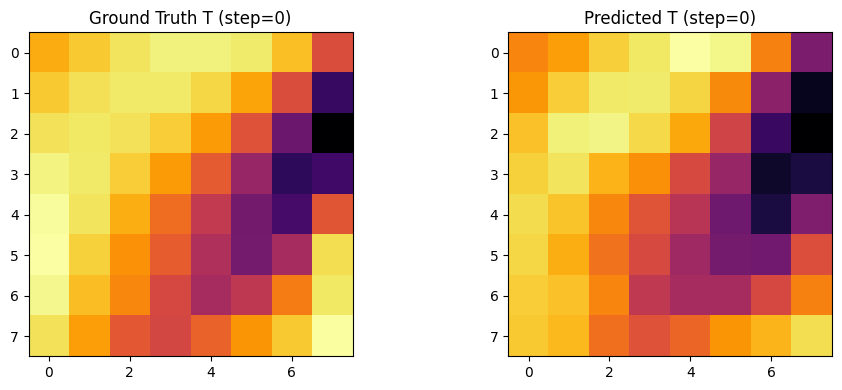

In [44]:
plot_comparison(forecasted, sample_target, level_index=0, step=0)

# Rollout a forecast

In [45]:
def rollout_forecast(model, initial_input, steps=5, device="cpu"):
    """
    Rolls forward predictions using the model's output as next input.

    Args:
        model: trained PyTorch model
        initial_input: torch.Tensor [C, 12, 8, 8] — input at t=0
        steps: number of time steps to forecast
        device: device string

    Returns:
        list of predicted frames: [T1, T2, ..., Tn] each [C, 12, 8, 8]
    """
    model.eval()
    current = initial_input.to(device).unsqueeze(0)  # [1, C, 12, 8, 8]
    predictions = []

    with torch.no_grad():
        for _ in range(steps):
            pred = model(current)  # output: [1, C, 12, 8, 8]
            predictions.append(pred.squeeze(0).cpu())
            current = pred  # feed back prediction as next input

    return predictions

In [46]:
steps = 5
input_0 = torch.from_numpy(inputs[0])  # t=0
true_seq = [torch.from_numpy(targets[i]) for i in range(steps)]  # t=1...t=5

pred_seq = rollout_forecast(model, input_0, steps=steps, device=device)

In [51]:
def plot_rollout_comparison_horizontal(pred_seq, true_seq, var="T", level_index=0, face=0):
    """
    Plot predicted vs ground truth in horizontal layout:
    5 columns (time steps), 2 rows (ground truth & prediction).
    """
    num_steps = len(pred_seq)
    fig, axs = plt.subplots(2, num_steps, figsize=(4 * num_steps, 8))

    pfull = pred_seq[0].shape[0] // 3
    var_offset = 0 if var == "T" else pfull if var == "U" else 2 * pfull
    ch = var_offset + level_index

    for t in range(num_steps):
        pred_face = pred_seq[t][ch][face].numpy()
        true_face = true_seq[t][ch][face].numpy()

        axs[0, t].imshow(true_face, cmap="inferno")
        axs[0, t].set_title(f"GT {var}, t={t+1}", fontsize=12)
        axs[0, t].axis("off")

        axs[1, t].imshow(pred_face, cmap="inferno")
        axs[1, t].set_title(f"Pred {var}, t={t+1}", fontsize=12)
        axs[1, t].axis("off")

    axs[0, 0].set_ylabel("Ground Truth", fontsize=14)
    axs[1, 0].set_ylabel("Prediction", fontsize=14)

    plt.tight_layout()
    plt.show()

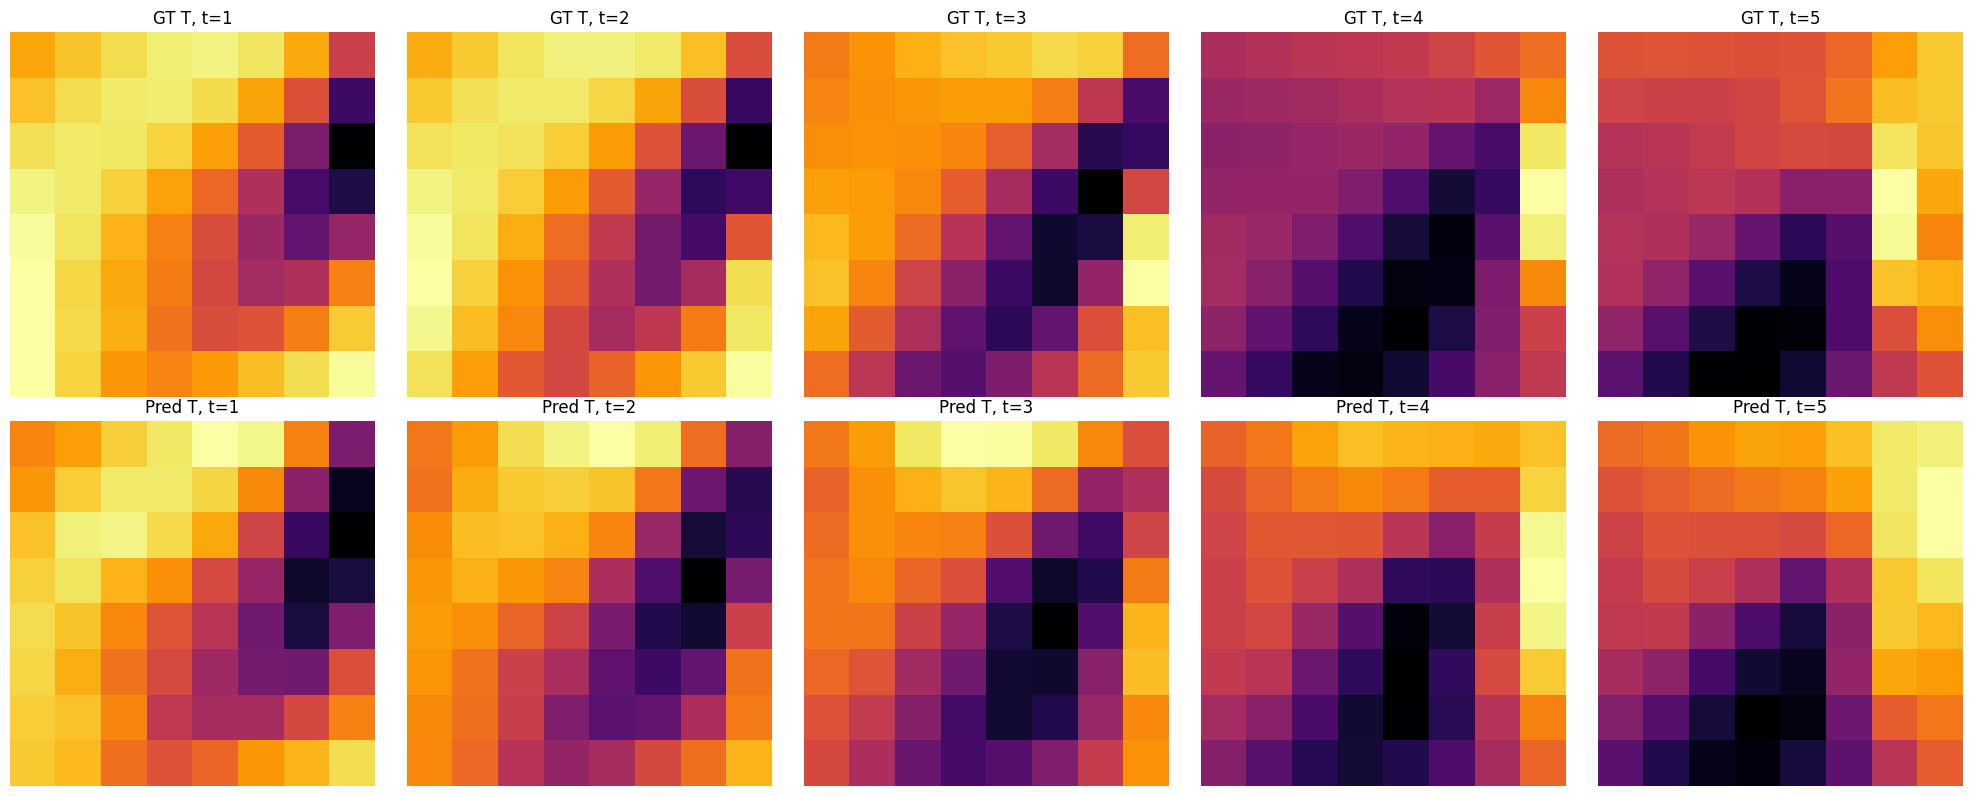

In [52]:
plot_rollout_comparison_horizontal(pred_seq, true_seq, var="T", level_index=0, face=0)